# VGG_Train_w_PreTrainModel 
DESCRIPTION: This notebook includes training and validation scripts for deep VGG model. 

Including transfering parameters from pretrained model to new model.

@author: Jian Zhong

In [1]:
## import modules
import os
import time
import datetime

import functools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import v2

import importlib

In [2]:
## import customized modules 
import Modules.Models.VGG as VGG
from Modules.Data.Transforms import (
    subtract_channel_mean, 
    subtract_const, 
    random_ch_shift_pca,
)
from Modules.TrainAndValidate.TrainValidate import (
    train_one_epoch, 
    validate_one_epoch, 
    validate_one_epoch_topk, 
    validate_one_epoch_topk_aug,
)

In [3]:
## create customized transforms

## subtract global mean channel background
train_data_ch_avg = torch.tensor([[[0.4914]],[[0.4822]],[[0.4465]]])
print(train_data_ch_avg.size())
subtract_ch_avg = functools.partial(subtract_const, const_val = train_data_ch_avg)

## random channel shifts
trainset_pca_eigenvecs = torch.tensor([[-0.5580,  0.7063,  0.4356], [-0.5775,  0.0464, -0.8151], [-0.5960, -0.7063,  0.3820]])
print(trainset_pca_eigenvecs.size())
trainset_pca_eigenvals = torch.tensor([0.1719, 0.0139, 0.0029])
print(trainset_pca_eigenvals.size())

random_ch_shift = functools.partial(random_ch_shift_pca, 
                                    pca_eigenvecs = trainset_pca_eigenvecs,
                                    pca_eigenvals = trainset_pca_eigenvals,
                                    random_paras = {"mean": 0, "std": 0.1},
                                   )

torch.Size([3, 1, 1])
torch.Size([3, 3])
torch.Size([3])


In [4]:
## define all data transform

## data transform for training
train_data_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale = True),
    v2.Lambda(subtract_ch_avg),
    v2.RandomHorizontalFlip(0.5),
    v2.Lambda(random_ch_shift),
])

## data transform for validation
validate_data_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale = True),
    v2.Lambda(subtract_ch_avg),
])

In [5]:
## load data set

## NOTE: the dataset_root_dir may need to be changed accordingly
dataset_root_dir = r"E:\Python\DataSet\TorchDataSet\CIFAR10"
train_data = torchvision.datasets.CIFAR10(
    root = dataset_root_dir,
    train = True,
    download = True,
    transform=train_data_transforms,
)
validate_data = torchvision.datasets.CIFAR10(
    root = dataset_root_dir,
    train = False,
    download = True,
    transform=validate_data_transforms,
)

print(f"train_data length: {len(train_data)}")
print(f"validate_data lenght: {len(validate_data)}")

Files already downloaded and verified
Files already downloaded and verified
train_data length: 50000
validate_data lenght: 10000


In [6]:
## create data loader

train_batch_size = 128
validate_batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size = train_batch_size, 
                                               shuffle = True)
validate_dataloader = torch.utils.data.DataLoader(validate_data, 
                                                  batch_size = validate_batch_size, 
                                                  shuffle = True)

Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


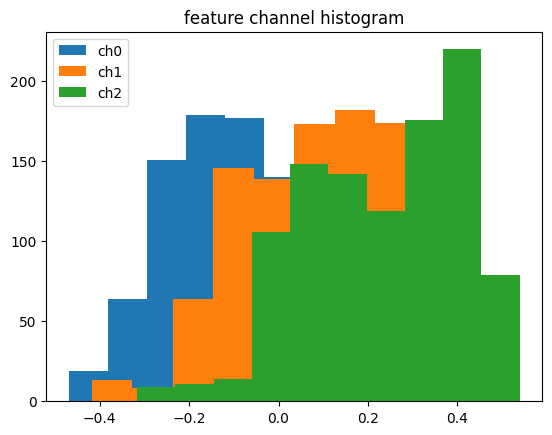

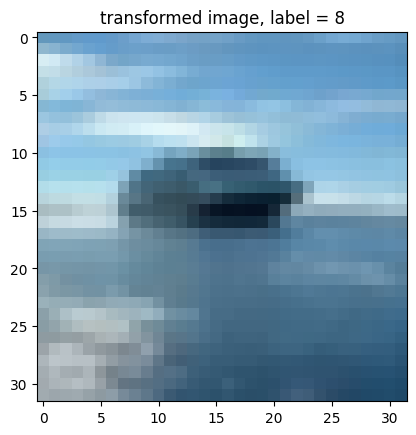

In [19]:
## check data

check_data_idx = 0

check_dataloader = train_dataloader

check_features, check_labels = next(iter(check_dataloader))

print(f"Feature batch shape: {check_features.size()}")
print(f"Labels batch shape: {check_labels.size()}")

check_feature = check_features[check_data_idx].squeeze().numpy()
check_image = (check_features[check_data_idx].squeeze()+train_data_ch_avg).numpy()
check_label = check_labels[check_data_idx].numpy()

plt.figure()
for i_ch in range(check_feature.shape[0]):
    plt.hist(check_feature[i_ch,...].reshape((-1,)), label = f"ch{i_ch}")
plt.legend()
plt.title(f"feature channel histogram")
plt.show()

plt.figure()
plt.imshow(np.rollaxis(check_image, 0, 3))
plt.title(f"transformed image, label = {check_label}")
plt.show()

In [25]:
## define model

## NOTE: input image width and height need to be adjusted based on data 
input_image_width = 32
input_image_height = 32

model_stacked_conv_list = [
    [ 
        {"nof_layers": 1, "in_channels": 3, "out_channels": 128,}, 
    
    ],
    [ 
        {"nof_layers": 2, "in_ckjhannels": 128, "out_channels": 256,}, 
    ],
    [ 
        {"nof_layers": 2, "in_channels": 256, "out_channels": 512, }, 
    ],
]

conv_image_reduce_ratio = 2**len(model_stacked_conv_list)
conv_final_image_width = input_image_width//conv_image_reduce_ratio
conv_final_image_height = input_image_height//conv_image_reduce_ratio

model_stacked_linear = [
    { "nof_layers": 2, "in_features": conv_final_image_width * conv_final_image_height * 512, "out_features": 1024, "dropout_p": 0.5},
    { "nof_layers": 1, "in_features": 1024, "out_features": 10, "activation": None}
]

model = VGG.VGG(
    stacked_conv_descriptors = model_stacked_conv_list,
    stacked_linear_descriptor = model_stacked_linear,
    enable_debug = False,
)

print(model)

VGG(
  (network): Sequential(
    (0): VGGStacked2DConv(
      (network): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): VGGStacked2DConv(
      (network): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): VGGStacked2DConv(
      (network): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6)

In [26]:
## load pretraine model 

## NOTE: the pretrain_model_file_path needs to be set according to your pretrained model
pretrain_model_file_path = r".\Results\model_2024-05-13-12-33-13.pt"

pretain_model = torch.load(pretrain_model_file_path)

print(pretain_model)

VGG(
  (network): Sequential(
    (0): VGGStacked2DConv(
      (network): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): VGGStacked2DConv(
      (network): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): VGGStacked2DConv(
      (network): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): VGGStackedLinear(
      (network): Sequential(
        (0): Linear(in_features=8192, out_features=1024, bias=True)
        (1): ReLU()
        (2): Dropout(

In [27]:
## Update parameters from pretrained model to new model

## NOTE: the model_from_pretrain_layer_mapping needs to be set according to your model achitecture
model_from_pretrain_layer_mapping = [
    [[0,0],[0,0]],
    [[2,0],[2,0]],
    [[4,0],[4,0]],
    [[7,0],[7,0]],
    [[7,5],[7,3]],
]

with torch.no_grad():
    for i_item in range(len(model_from_pretrain_layer_mapping)):
        cur_model_layers, cur_pretrain_layers = model_from_pretrain_layer_mapping[i_item]
        # print(cur_model_layers, cur_pretrain_layers)
        cur_pretrain_weight = None
        cur_pretrain_bias = None
        if len(cur_pretrain_layers) == 1:
            cur_pretrain_weight = pretain_model.network[cur_pretrain_layers[0]].weight
            cur_pretrain_bias = pretain_model.network[cur_pretrain_layers[0]].bias
        elif len(cur_pretrain_layers) == 2:
            cur_pretrain_weight = pretain_model.network[cur_pretrain_layers[0]].network[cur_pretrain_layers[1]].weight
            cur_pretrain_bias = pretain_model.network[cur_pretrain_layers[0]].network[cur_pretrain_layers[1]].bias
        else:
            continue

        if len(cur_model_layers) == 1:
            model.network[cur_model_layers[0]].weight = cur_pretrain_weight
            model.network[cur_model_layers[0]].bias = cur_pretrain_bias
        elif len(cur_model_layers) == 2:
            model.network[cur_model_layers[0]].network[cur_model_layers[1]].weight = cur_pretrain_weight
            model.network[cur_model_layers[0]].network[cur_model_layers[1]].bias = cur_pretrain_bias
        else:
            continue

In [28]:
## quickly check if model can run

model.to("cpu")
with torch.no_grad():
    check_features, check_labels = next(iter(train_dataloader))
    model.eval()
    print(model(check_features).size())

torch.Size([128, 10])


In [29]:
## training configuration

loss_func = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 1E-2, momentum = 0.9, weight_decay= 5E-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode = "max",
    factor = 0.1,
    patience = 10,
    threshold = 1E-3,
    min_lr = 0,
)

top_k = 1

validate_transforms = [None, torchvision.transforms.functional.hflip]

nof_epochs = 100

In [30]:
## use parallel computing if possible

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

model = model.to(device)

Using cuda device


In [31]:
## training and validationg loop

learning_rates = torch.zeros((nof_epochs,))
train_losses = torch.zeros((nof_epochs,))
validate_losses = torch.zeros((nof_epochs,))
validate_accuracies = torch.zeros((nof_epochs,))

for i_epoch in range(nof_epochs):
    print(f" ------ Epoch {i_epoch} ------ ")

    cur_lr = optimizer.param_groups[0]['lr'];
    
    print(f"current lr = {cur_lr}")
    learning_rates[i_epoch] = cur_lr

    cur_train_loss = train_one_epoch(model, 
                                     train_dataloader,  
                                     loss_func, 
                                     optimizer, 
                                     device)
    cur_validate_loss, cur_validate_accuracy = validate_one_epoch_topk_aug(model, 
                                                                           validate_dataloader, 
                                                                           loss_func, 
                                                                           validate_transforms, 
                                                                           device, 
                                                                           top_k)
    
    train_losses[i_epoch] = cur_train_loss
    validate_losses[i_epoch] =  cur_validate_loss
    validate_accuracies[i_epoch] = cur_validate_accuracy

    scheduler.step(cur_validate_accuracy)
    
    print("\n")

 ------ Epoch 0 ------ 
current lr = 0.01
batch 0 loss: 2.302478
batch 100 loss: 2.302595
batch 200 loss: 2.302569
batch 300 loss: 2.302553
Train: Avg loss: 2.302542
Validate: top1 Accuracy: 10.00%, Avg loss: 2.302432


 ------ Epoch 1 ------ 
current lr = 0.01
batch 0 loss: 2.302400
batch 100 loss: 2.302369
batch 200 loss: 2.302285
batch 300 loss: 2.301995
Train: Avg loss: 2.299893
Validate: top1 Accuracy: 10.00%, Avg loss: 2.273617


 ------ Epoch 2 ------ 
current lr = 0.01
batch 0 loss: 2.277551
batch 100 loss: 2.253135
batch 200 loss: 2.220084
batch 300 loss: 2.195680
Train: Avg loss: 2.175577
Validate: top1 Accuracy: 37.42%, Avg loss: 2.080957


 ------ Epoch 3 ------ 
current lr = 0.01
batch 0 loss: 2.110549
batch 100 loss: 2.093330
batch 200 loss: 2.075740
batch 300 loss: 2.066428
Train: Avg loss: 2.060982
Validate: top1 Accuracy: 39.28%, Avg loss: 2.059872


 ------ Epoch 4 ------ 
current lr = 0.01
batch 0 loss: 2.089326
batch 100 loss: 2.018615
batch 200 loss: 2.016724
batch

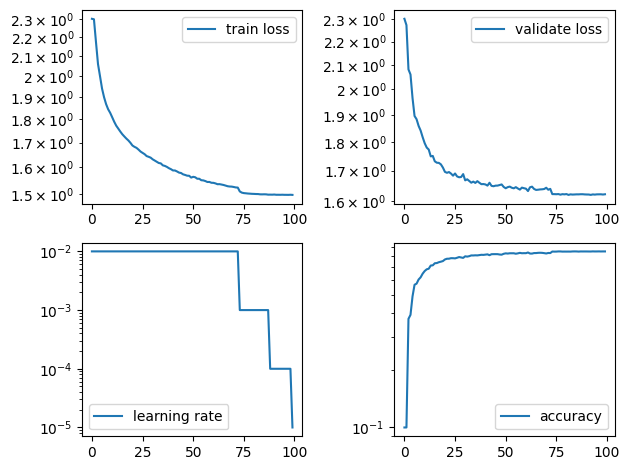

In [32]:
# plot training and validation metrics
plt.figure()
plt.subplot(2,2,1)
plt.plot(train_losses, label = "train loss")
plt.yscale("log")
plt.legend()
plt.subplot(2,2,2)
plt.plot(validate_losses, label = "validate loss")
plt.yscale("log")
plt.legend()
plt.subplot(2,2,3)
plt.plot(learning_rates, label = "learning rate")
plt.yscale("log")
plt.legend()
plt.subplot(2,2,4)
plt.plot(validate_accuracies, label = "accuracy")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
## validate for more top k calssification
for i_topk in range(1, 6):    
    cur_validate_loss, cur_validate_accuracy = validate_one_epoch_topk_aug(model, 
                                                                           validate_dataloader, 
                                                                           loss_func, 
                                                                           validate_transforms, 
                                                                           device, 
                                                                           i_topk)

Validate: top1 Accuracy: 84.88%, Avg loss: 1.621171
Validate: top2 Accuracy: 93.95%, Avg loss: 1.620775
Validate: top3 Accuracy: 96.91%, Avg loss: 1.619853
Validate: top4 Accuracy: 98.23%, Avg loss: 1.620917
Validate: top5 Accuracy: 98.99%, Avg loss: 1.621248


In [34]:
## save model and model parameters

dst_dir_path = r".\Results"
if not os.path.isdir(dst_dir_path):
    os.makedirs(dst_dir_path)

dst_model_name = "model_" + time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
dst_model_file_name = dst_model_name + ".pt"
dst_modelstate_file_name = dst_model_name + "_state.pt"

dst_model_file_path = os.path.join(dst_dir_path, dst_model_file_name)
torch.save(model, dst_model_file_path)
print("model saved to: " + dst_model_file_path)

dst_modelstate_file_path = os.path.join(dst_dir_path, dst_modelstate_file_name)
torch.save(model.state_dict(), dst_modelstate_file_path)
print("model state saved to: " + dst_modelstate_file_path)

model saved to: .\Results\model_2024-05-13-19-02-15.pt
model state saved to: .\Results\model_2024-05-13-19-02-15_state.pt
